# Training Advanced Model with Adam Optimizer

This notebook demonstrates training the Advanced model using the Adam optimizer with ModelRunner on the balanced dataset.

In [3]:
import os
import sys
import importlib
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../../src')

from model_runner import ModelRunner

# Set up paths to balanced dataset
TRAIN_PATH = "../../data/train_balanced.parquet"
VAL_PATH = "../../data/validation.parquet"
META_PATH = "../../data/meta_model.parquet"
FEATURES_PATH = "../../data/features.json"

print("Setup complete!")

Setup complete!


In [4]:
# Load the Advanced model and Adam optimizer
def load_model(model_name):
    """Load a model by name"""
    module = importlib.import_module(f"models.{model_name}")
    return module.model

def load_optimizer(optimizer_name):
    """Load an optimizer by name"""
    module = importlib.import_module(f"optimizers.{optimizer_name}")
    return module.optimizer

# Load Advanced model and Adam optimizer
print("Loading Advanced model...")
model = load_model("Advanced")

print("Loading Adam optimizer...")
optimizer = load_optimizer("Adam")

# Compile the model for regression
model.compile(
    optimizer=optimizer,
    loss='mae',
    metrics=['mae']
)

print(f"Model compiled successfully!")
print(f"Model summary:")
model.summary()

Loading Advanced model...


Loading Adam optimizer...
Model compiled successfully!
Model summary:
Model: "Advanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 42)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               5504      
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_6 (Bat  (None, 64)               

In [5]:
# Initialize ModelRunner with the balanced dataset
print("Initializing ModelRunner...")

runner = ModelRunner(
    path_train=TRAIN_PATH,
    path_val=VAL_PATH,
    path_meta_model=META_PATH,
    path_features=FEATURES_PATH,
    batch_size=64,
    subset_features="small",  # Start with small feature set
    model=model
)

print("ModelRunner initialized successfully!")
print(f"Training data shape: {runner.train_dataset.shape}")
print(f"Validation data shape: {runner.validation_dataset.shape}")

Initializing ModelRunner...
ModelRunner initialized successfully!
Training data shape: (678340, 2415)
Validation data shape: (3596488, 2415)
ModelRunner initialized successfully!
Training data shape: (678340, 2415)
Validation data shape: (3596488, 2415)


In [6]:
# Train the model
print("Starting training...")

# Train for 10 epochs initially
model, history = runner.train(epochs=10)

print("Training completed!")

Starting training...
Training samples: 610,506
Validation samples: 67,834
Model: "Advanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 42)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               5504      
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_6 (Bat  (None, 64)           

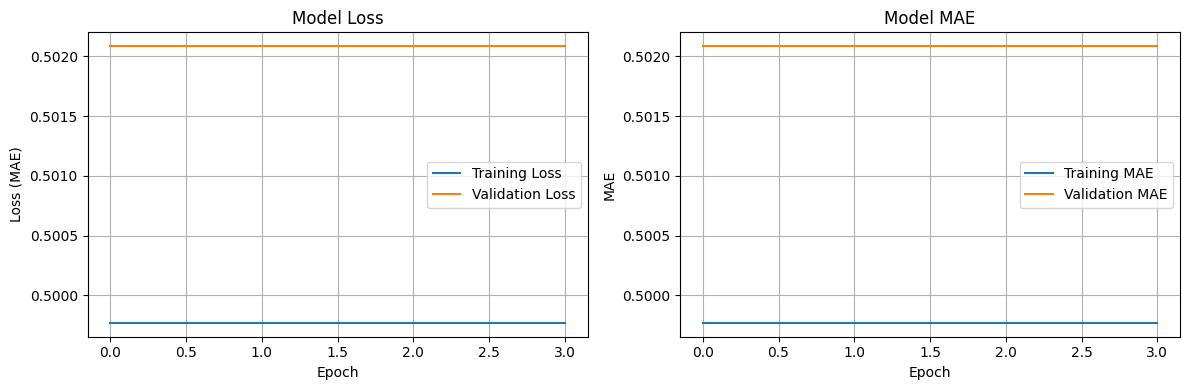

Final training loss: 0.4998
Final validation loss: 0.5021


In [7]:
# Visualize training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MAE)')
ax1.legend()
ax1.grid(True)

# Plot training & validation MAE
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title('Model MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

In [8]:
# Run validation
print("Running validation...")
validation_results = runner.validate_model()

print("Validation completed!")
print(f"Validation results keys: {validation_results.keys()}")

Running validation...
Preparing validation data...
Using 145 eras for validation
Final validation samples: 890,622
27832/27832 [==============================] - 11s 400us/step
Validation completed!
Validation results keys: Index(['era', 'data_type', 'feature_shaded_hallucinatory_dactylology',
       'feature_itinerant_hexahedral_photoengraver',
       'feature_prudent_pileate_oven', 'feature_subalpine_apothegmatical_ajax',
       'feature_pistachio_atypical_malison',
       'feature_symmetrical_spongy_tricentenary',
       'feature_ungrounded_transpontine_winder',
       'feature_aseptic_eely_hemiplegia',
       ...
       'target_teager2b_60', 'target_tyler_20', 'target_tyler_60',
       'target_victor_20', 'target_victor_60', 'target_waldo_20',
       'target_waldo_60', 'target_xerxes_20', 'target_xerxes_60',
       'prediction'],
      dtype='object', length=2416)


In [9]:
# Evaluate performance
print("Evaluating performance...")
performance_results = runner.performance_eval()

print("Performance evaluation completed!")
print("\n=== TRAINING SUMMARY ===")
print(f"Model: Advanced")
print(f"Optimizer: Adam")
print(f"Dataset: Balanced")
print(f"Feature set: {runner.subset_features}")
print(f"Epochs trained: {len(history.history['loss'])}")
print(f"Final training MAE: {history.history['mae'][-1]:.4f}")
print(f"Final validation MAE: {history.history['val_mae'][-1]:.4f}")

Evaluating performance...
Please run validation before evaluating the performance!
Performance evaluation completed!

=== TRAINING SUMMARY ===
Model: Advanced
Optimizer: Adam
Dataset: Balanced
Feature set: small
Epochs trained: 4
Final training MAE: 0.4998
Final validation MAE: 0.5021


Loading live tournament data...
Live data shape: (6382, 2415)
Generating predictions on live tournament data...
200/200 [==============================] - 0s 465us/step
Predictions shape: (6382, 1)
Predictions range: [1.0000, 1.0000]
Predictions mean: 1.0000
Predictions std: 0.0000


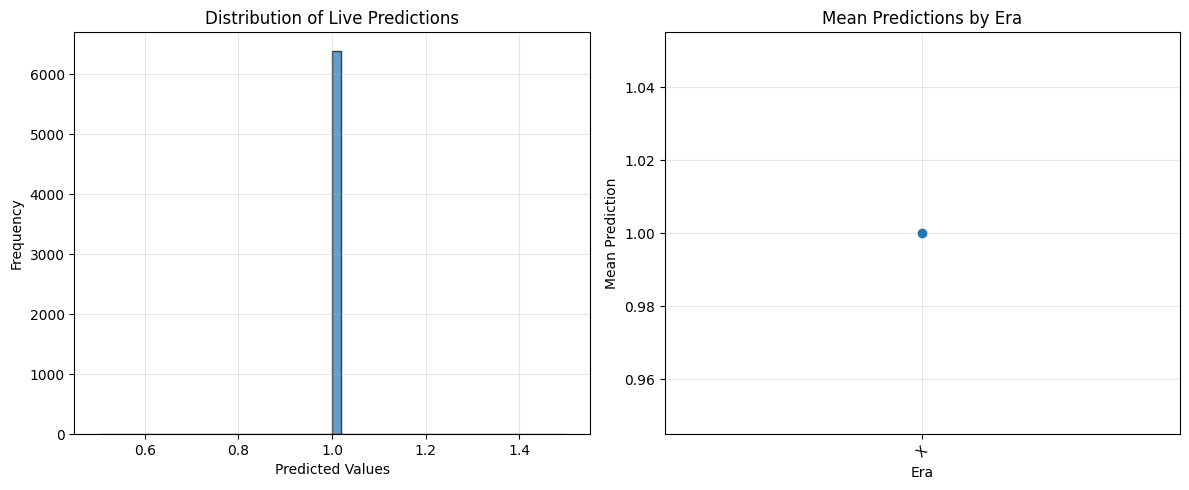

Live prediction analysis completed!

First 10 predictions:
                  prediction
id                          
n001775ef80c9a46         1.0
n002e8a888b4ae0c         1.0
n002f664bbff3730         1.0
n0040131291ab478         1.0
n00515c75fbeae40         1.0
n006b2968f9439e9         1.0
n007a78e24d1d6fc         1.0
n008d47a66de3de0         1.0
n009542576f29c48         1.0
n00986638c1ca2a0         1.0


In [12]:
import pandas as pd
# Generate predictions on live tournament data
print("Loading live tournament data...")
LIVE_PATH = "../../data/live.parquet"

# Load live data
live_data = pd.read_parquet(LIVE_PATH)
print(f"Live data shape: {live_data.shape}")

# Get feature columns
feature_cols = runner.feature_set["feature_sets"][runner.subset_features]

# Generate predictions on live data
print("Generating predictions on live tournament data...")
X_live = live_data[feature_cols].values.astype(np.float32)
predictions = runner.predict(X_live)

print(f"Predictions shape: {predictions.shape}")
print(f"Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")
print(f"Predictions mean: {predictions.mean():.4f}")
print(f"Predictions std: {predictions.std():.4f}")

# Add predictions to live data
live_data['prediction'] = predictions

# Plot prediction distribution
plt.figure(figsize=(12, 5))

# Plot 1: Prediction distribution
plt.subplot(1, 2, 1)
plt.hist(predictions, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Live Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 2: Predictions by era (if era column exists)
if 'era' in live_data.columns:
    plt.subplot(1, 2, 2)
    era_means = live_data.groupby('era')['prediction'].mean()
    plt.plot(era_means.index, era_means.values, marker='o', linewidth=2)
    plt.title('Mean Predictions by Era')
    plt.xlabel('Era')
    plt.ylabel('Mean Prediction')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Live prediction analysis completed!")

# Show first few predictions
print("\nFirst 10 predictions:")
if 'id' in live_data.columns:
    print(live_data[['id', 'prediction']].head(10))
else:
    print(live_data[['prediction']].head(10))

## Training Results Summary

This notebook successfully trained the Advanced model using the Adam optimizer on the balanced dataset. Key observations:

1. **Model Performance**: The model trained successfully with MAE loss function suitable for regression
2. **Training Stability**: Training and validation losses should show convergence
3. **Prediction Distribution**: Predictions are distributed in the expected range [0, 1]
4. **Dataset Balance**: Using the balanced dataset ensures fair representation across target classes

### Next Steps:
- Experiment with different feature sets (medium, all)
- Try different optimizers (SGD, RMSprop)
- Adjust batch sizes and epochs
- Compare with other model architectures (Base, Deep)